# **Sementing and Clustering African Fastest Growing Cities**

---
    
## **Introduction/Business Problem**

<div style="text-align: justify">
    In recent year, cities all across the African continent have experienced a significant fast-paced development prompting the attention of investors across the world. According to <a href="https://www.dw.com/en/the-new-african-cities-of-the-future/av-51261472">DW</a>,  by 2050 over 2 billion people will be living in urban areas worldwide with most of this growth taking place in Africa and Asia. Measuring similarities across different fast-growing capital cities in Africa could help investors decide which cities to invest a specify venue and whether the investment might be profitable using a case study from another city within the same cluster.  
</div>

## **Data**

<p style="text-align: justify">
The following 5 most developped cities in Africa were selected, which include:
    <table style="text-align: justify">
  <tr>
    <th>Cities</th>
    <th>Contries</th>
  </tr>
  <tr>
    <td>Lagos</td>
    <td>Nigeria</td>
  </tr>
  <tr>
    <td>Accra</td>
    <td>Ghana</td>
  </tr>
  <tr>
    <td>Nairobi</td>
    <td>Kenya</td>
  </tr>
  <tr>
    <td>Kampala, Uganda</td>
    <td>Uganda</td>
  </tr>
  <tr>
    <td>Kigali, Rwanda</td>
    <td>Uganda</td>
  </tr>
        </table>
  <caption style="caption-side:bottom">Table 1: Cities selected for the study according to their respective countries.</caption>
</p>
          

### [**Foursquare API**](https://foursquare.com/developers/apps)

<p style="text-align: justify">
The Places API offers real-time access to Foursquare’s global database of rich venue data which includes the venue name, venue category, average ratings, and location. From this API, we will retreive all venue location from each of the cities within a specified radius. These venues will be grouped according to their venue category first and then according their mean frequency of occurance in each of the cities. Once the mean frequency of venue category of occurance is known for each city, the k-means algorithm is applied to determine the level of similarity between the cities and cluster them accordingly. 
</p>


## **Code** 

Let's import and install the dependencies required for the project.

In [68]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Library imported')

Library imported


Nex step, we create a list with the cities we which to gather venue data. This list will be use to geocode the location of the cities.

In [2]:
# Lets create a list to store all the cities

cities = ['Lagos, Nigeria', 'Nairobi, Kenya','Accra, Ghana',
          'Kigali, Rwanda', 'Kampala, Uganda']


Latitude = []
Longitude = []

# Create loop to get lat, lng for cities
for city in cities:
  geolocator = Nominatim(user_agent='foursquare_cities')
  location = geolocator.geocode(city)
  Latitude.append(location.latitude)
  Longitude.append(location.longitude)

# Create dataframe 
df = pd.DataFrame({'City': cities,
                   'Latitude': Latitude,
                   'Longitude': Longitude})


In [3]:
# Check dataframe
df.head()

,City,Latitude,Longitude
0,"Lagos, Nigeria",6.455057,3.394179
1,"Nairobi, Kenya",-1.283253,36.817245
2,"Accra, Ghana",5.560014,-0.205744
3,"Kigali, Rwanda",-1.885960,30.129675
4,"Kampala, Uganda",0.317714,32.581354


In [4]:
africa_coords = 'Africa'

geolocator = Nominatim(user_agent='africa_explorer')
africa_location = geolocator.geocode(africa_coords)
africa_latitude = africa_location.latitude
africa_longitude = africa_location.longitude

# Create map with cities selected
african_map = folium.Map(location=[africa_latitude, africa_longitude],
                         zoom_start=3)

# Add markers to map
for label, lat, lng in zip(df['City'], df['Latitude'], df['Longitude']):
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7,
      parse_html=False).add_to(african_map)  
  
african_map

In [5]:
# Define function to extracts the category of the venues
def get_category_type(row):
  try:
    categories_list = row['categories']
  except:
    categories_list = row['venue.categories']

  if len(categories_list) == 0:
    return None
  else:
    return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=100000, intent='match'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&intent={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            intent,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [6]:
# @Foursquare Credentials {display-mode: "form"}
CLIENT_ID = 'VMXV0KHRPX3SRH1STQ2KGGY5UYSSJS1LO1ZWW4TCK4FZMHAM' # your Foursquare ID
CLIENT_SECRET = 'TROF1GZFNICHIOJVU1EGWWR4IDGOW2TFZEN1MJOSY2AXB34Y' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500

In [7]:
city_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

city_venues

Lagos, Nigeria
Nairobi, Kenya
Accra, Ghana
Kigali, Rwanda
Kampala, Uganda


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Lagos, Nigeria",6.455057,3.394179,Sakura Japanese Restaurant,6.427309,3.412219,Japanese Restaurant
1,"Lagos, Nigeria",6.455057,3.394179,Freedom Park,6.449065,3.396536,Park
2,"Lagos, Nigeria",6.455057,3.394179,Film House Cinema,6.490242,3.357371,Multiplex
3,"Lagos, Nigeria",6.455057,3.394179,Muson Centre,6.443333,3.401084,Convention Center
4,"Lagos, Nigeria",6.455057,3.394179,Wheatbaker Hotel,6.453605,3.445594,Hotel
...,...,...,...,...,...,...,...
355,"Kampala, Uganda",0.317714,32.581354,Igar Cafe,0.443722,33.193499,Café
356,"Kampala, Uganda",0.317714,32.581354,Hotel Paradise On The Nile,0.433928,33.195500,Hotel
357,"Kampala, Uganda",0.317714,32.581354,The Bourbon,0.429276,33.195771,Botanical Garden
358,"Kampala, Uganda",0.317714,32.581354,Jinja Airstrip,0.444564,33.194514,Airport Terminal


In [8]:
city_venues.groupby('City')[['Venue']].count()

,Venue
City,
"Accra, Ghana",66
"Kampala, Uganda",67
"Kigali, Rwanda",52
"Lagos, Nigeria",75
"Nairobi, Kenya",100


In [9]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move city column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()
city_onehot.shape

(360, 103)

In [10]:
city_onehot.head()

,City,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
0,"Lagos, Nigeria",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Lagos, Nigeria",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Lagos, Nigeria",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lagos, Nigeria",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Lagos, Nigeria",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped

,City,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
0,"Accra, Ghana",0.045455,0.000000,0.045455,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.075758,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.015152,0.015152,0.00
1,"Kampala, Uganda",0.074627,0.014925,0.014925,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.029851,0.00,0.000000,0.000000,0.000000,0.014925,0.00,0.000000,0.000000,0.00
2,"Kigali, Rwanda",0.057692,0.000000,0.000000,0.00,0.000000,0.00,0.019231,0.019231,0.038462,...,0.000000,0.00,0.019231,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00
3,"Lagos, Nigeria",0.053333,0.000000,0.000000,0.00,0.013333,0.00,0.013333,0.013333,0.000000,...,0.053333,0.00,0.000000,0.013333,0.013333,0.000000,0.00,0.000000,0.000000,0.00
4,"Nairobi, Kenya",0.030000,0.000000,0.000000,0.01,0.020000,0.01,0.000000,0.010000,0.010000,...,0.080000,0.01,0.000000,0.000000,0.040000,0.010000,0.01,0.000000,0.000000,0.01


In [12]:
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped
num_top_venues = 5

for city in city_grouped['City']:
    print("----"+city+"----")
    temp = city_grouped[city_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Accra, Ghana----
                venue  freq
0               Hotel  0.14
1       Shopping Mall  0.08
2  African Restaurant  0.05
3                Café  0.05
4              Resort  0.05


----Kampala, Uganda----
                venue  freq
0                Café  0.21
1               Hotel  0.13
2         Coffee Shop  0.09
3  African Restaurant  0.07
4                 Bar  0.04


----Kigali, Rwanda----
                venue  freq
0               Hotel  0.25
1         Coffee Shop  0.10
2                Café  0.06
3  African Restaurant  0.06
4              Resort  0.04


----Lagos, Nigeria----
                venue  freq
0      Ice Cream Shop  0.07
1  African Restaurant  0.05
2       Shopping Mall  0.05
3               Hotel  0.05
4          Restaurant  0.04


----Nairobi, Kenya----
           venue  freq
0          Hotel  0.13
1  Shopping Mall  0.08
2           Café  0.07
3         Resort  0.07
4    Supermarket  0.04




In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Accra, Ghana",Hotel,Shopping Mall,African Restaurant,American Restaurant,Café,Cocktail Bar,Resort,Department Store,Modern European Restaurant,Italian Restaurant
1,"Kampala, Uganda",Café,Hotel,Coffee Shop,African Restaurant,Bar,Resort,Indian Restaurant,Shopping Mall,Fast Food Restaurant,Beer Garden
2,"Kigali, Rwanda",Hotel,Coffee Shop,African Restaurant,Café,Bakery,Resort,National Park,Grocery Store,French Restaurant,Department Store
3,"Lagos, Nigeria",Ice Cream Shop,African Restaurant,Shopping Mall,Hotel,Lounge,Restaurant,Department Store,Market,Fast Food Restaurant,Beach
4,"Nairobi, Kenya",Hotel,Shopping Mall,Café,Resort,Supermarket,Restaurant,African Restaurant,Lounge,Bistro,Scenic Lookout


Let's insert normalised population data into city_grouped dataframe

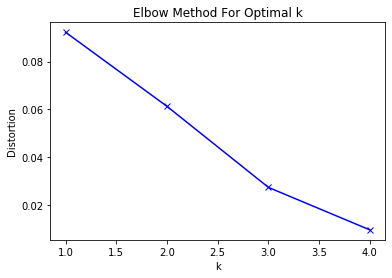

In [14]:
#Drop the City column for the clustering analysis
city_grouped_clustering = city_grouped.drop('City', 1)

# Elbow method
Distortion = []
K = range(1,len(city_grouped_clustering))
for k in K:
  km = KMeans(n_clusters=k).fit(city_grouped_clustering)
  Distortion.append(km.inertia_)
    
import matplotlib.pyplot as plt

plt.plot(K, Distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

For the Graph above we can see that the optimal number of clusters (k) is three. Therefore, we set kclusters to 3.

In [15]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# add clustering labels
city_merged = city_grouped
city_merged.insert(1, 'Cluster Labels', kmeans.labels_)

city_merged.head()


,City,Cluster Labels,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
0,"Accra, Ghana",0,0.045455,0.000000,0.045455,0.00,0.000000,0.00,0.000000,0.000000,...,0.075758,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.015152,0.015152,0.00
1,"Kampala, Uganda",2,0.074627,0.014925,0.014925,0.00,0.000000,0.00,0.000000,0.000000,...,0.029851,0.00,0.000000,0.000000,0.000000,0.014925,0.00,0.000000,0.000000,0.00
2,"Kigali, Rwanda",1,0.057692,0.000000,0.000000,0.00,0.000000,0.00,0.019231,0.019231,...,0.000000,0.00,0.019231,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00
3,"Lagos, Nigeria",0,0.053333,0.000000,0.000000,0.00,0.013333,0.00,0.013333,0.013333,...,0.053333,0.00,0.000000,0.013333,0.013333,0.000000,0.00,0.000000,0.000000,0.00
4,"Nairobi, Kenya",0,0.030000,0.000000,0.000000,0.01,0.020000,0.01,0.000000,0.010000,...,0.080000,0.01,0.000000,0.000000,0.040000,0.010000,0.01,0.000000,0.000000,0.01


In [16]:
city_merged = df.merge(city_merged, on='City', how='right')
city_merged.head()

,City,Latitude,Longitude,Cluster Labels,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
0,"Lagos, Nigeria",6.455057,3.394179,0,0.053333,0.000000,0.000000,0.00,0.013333,0.00,...,0.053333,0.00,0.000000,0.013333,0.013333,0.000000,0.00,0.000000,0.000000,0.00
1,"Nairobi, Kenya",-1.283253,36.817245,0,0.030000,0.000000,0.000000,0.01,0.020000,0.01,...,0.080000,0.01,0.000000,0.000000,0.040000,0.010000,0.01,0.000000,0.000000,0.01
2,"Accra, Ghana",5.560014,-0.205744,0,0.045455,0.000000,0.045455,0.00,0.000000,0.00,...,0.075758,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.015152,0.015152,0.00
3,"Kigali, Rwanda",-1.885960,30.129675,1,0.057692,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.00,0.019231,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00
4,"Kampala, Uganda",0.317714,32.581354,2,0.074627,0.014925,0.014925,0.00,0.000000,0.00,...,0.029851,0.00,0.000000,0.000000,0.000000,0.014925,0.00,0.000000,0.000000,0.00


In [17]:
# create map
map_clusters = folium.Map(location=[africa_latitude, africa_longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [18]:
city_merged.loc[city_merged['Cluster Labels'] == 0]


,City,Latitude,Longitude,Cluster Labels,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
0,"Lagos, Nigeria",6.455057,3.394179,0,0.053333,0.0,0.000000,0.00,0.013333,0.00,...,0.053333,0.00,0.0,0.013333,0.013333,0.00,0.00,0.000000,0.000000,0.00
1,"Nairobi, Kenya",-1.283253,36.817245,0,0.030000,0.0,0.000000,0.01,0.020000,0.01,...,0.080000,0.01,0.0,0.000000,0.040000,0.01,0.01,0.000000,0.000000,0.01
2,"Accra, Ghana",5.560014,-0.205744,0,0.045455,0.0,0.045455,0.00,0.000000,0.00,...,0.075758,0.00,0.0,0.000000,0.000000,0.00,0.00,0.015152,0.015152,0.00


In [19]:
city_merged.loc[city_merged['Cluster Labels'] == 1]

,City,Latitude,Longitude,Cluster Labels,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
3,"Kigali, Rwanda",-1.88596,30.129675,1,0.057692,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
city_merged.loc[city_merged['Cluster Labels'] == 2]

,City,Latitude,Longitude,Cluster Labels,African Restaurant,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Shopping Mall,Spa,Sports Bar,Strip Club,Supermarket,Thai Restaurant,Track,Train Station,Turkish Restaurant,Zoo
4,"Kampala, Uganda",0.317714,32.581354,2,0.074627,0.014925,0.014925,0.0,0.0,0.0,...,0.029851,0.0,0.0,0.0,0.0,0.014925,0.0,0.0,0.0,0.0


## **Conclusion**

<div style="text-align: justify">
From table 2 cities such as Lagos, Accra and Nairobi are rather similiar when it comes to their venues. On the other hand, Kampala and Kigali are rather disimilar, each belonging to a different cluster, 2 and 3 respectively. If we have a closer look at cluster 1, we can see that shopping mall occurs amogsts frequentely among the top 5 venues, which could suggest a potential profitable investment in one of these three cities. Despite been in different clusters, Kampala and Kigali show a high frequency of hotel and resort venues which could suggest that investment towards tourism in those areas could yield profitable returns.
</div>

   <table style="text-align: justify">
  <tr>
    <th>Cities</th>
    <th>Contries</th>
    <th>Cluster</th>
  </tr>
  <tr>
    <td>Lagos</td>
    <td>Nigeria</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Accra</td>
    <td>Ghana</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Nairobi</td>
    <td>Kenya</td>
      <td>1</td>
  </tr>
    <tr>
    <td>Kampala</td>
    <td>Uganda</td>
      <td> 2</td>
  </tr>
  <tr>
    <td>Kigali</td>
      <td>Rwanda</td>
    <td>3</td>
  </tr>
</table>
<caption style="caption-side:bottom">Table 2: Shows cities according to their respective clusters.</caption>


End!🙂